In [65]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy.stats import maxwell
from scipy.stats import norm

In [66]:
rcut = 3.0  ##### Cut-off distance. If distance between atoms is greater than this, interaction between them is ignored.
rcutsquare = rcut**2
g2 = 1./rcutsquare
g6 = g2*g2*g2
potcut = 4.*g6*(g6-1) ##### Term to be subtracted from pair potential energy

In [67]:
##### Function to compute acceleration for a pair of atoms. r12 is relative displacement of atoms.
def acceleration(r12): 
    r12square = np.dot(r12,r12)
    f2 = 1./r12square
    f6 = f2*f2*f2
    acc = 48.*f2*f6*(f6-0.5)*r12
    return acc

In [68]:
#### Function to compute potential energy for the system of particles. `pos' is the array of position vectors.
def potentialenergy(pos):
    potential = 0.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])  ### rij is the separation b/w the particles and we need the minimum distance
            rijsquare = np.dot(rij,rij)
            if rijsquare < rcutsquare: # Imposing interaction cut-off
                f2 = 1./rijsquare
                f6 = f2*f2*f2
                potential += 4.*f6*(f6-1.) - potcut
    return potential

In [69]:
number = 5
delta_r = 0.1
Natoms = number**2  # No. of atoms
Ratom = 0.5  ### Radius of atom used to illustrate the atom as a sphere. (sigma is the dimensionless scale here so ratom= sigma * 0.5)
rho = 0.2 ### Number Density
L = math.pow(Natoms/rho,0.5) # Length of a side of the square containing the gas.
T0 = 120. # Natural temperature scale, T0 = epsilon/k.
T = 2.5   # Temperature in Kelvin # mean K.E. equal to this
dt = 1E-2  # Time step for Verlet Algorithm
length = int(0.5*L/delta_r)
print(length)
print(L)

55
11.180339887498949


In [70]:
###### Atoms are arranged initially in a square lattice configuration with spacing between neighbors equal to equilibrium separation of the potential energy.

equilib_sep = math.pow(2.,1./6.)  ## Equilibrium separation of atoms
wall_spacing = (L-(number-1)*equilib_sep)/2.  ## Distance betwee the walls and the initial array of atoms.
poslist = []  # List for positions of atoms
vlist = []   # List for velocities




################  Initialize positions and velocities ##############################################
x, y = wall_spacing, wall_spacing

for i in range(number):
    for j in range(number):
        xi, yi = x + equilib_sep*j, y + equilib_sep*i
        poslist.append((xi,yi))


####### Initially, all particles have the same speed but random velocity directions. ################
v0 = math.sqrt(2.*T/T0)

for i in range(Natoms):
    phi = 2*np.pi*np.random.random()
    vx = v0*np.cos(phi)
    vy = v0*np.sin(phi)
    vlist.append((vx,vy))
###################################################################################################




pos = np.array(poslist)  ### Converts lists to numpy arrays
v = np.array(vlist) ## Scaled velocity


V_cm = np.sum(v, axis = 0)/Natoms ## Correcting for CM velocity.
V = np.array([V_cm,]*Natoms)
v -= V  


In [71]:
time = 0. # Initial time.
t_final = 200. # Time upto which simulation is carried out.

potential_energy = potentialenergy(pos)
kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
energy = kinetic_energy + potential_energy
Time_List = [time]
Energy_List = [energy]
PotentialEnergy_List = [potential_energy]
KineticEnergy_List = [kinetic_energy]
V_array=[]
k_m=T
iterations = int(t_final/dt) # Number of iterations of the Verlet Algorithm.

In [72]:
r_list=np.zeros(length)
dist_list=np.zeros(length)
counter=0
def RDF (positions,length):
    dist_array=[]
    r_array=[]
    for i in range(0,length):
        count=0
        r= (i+1/2)*delta_r
        for i in range(Natoms-1):
            for j in range(i+1,Natoms):
                rij = positions[i] - positions[j]
                for l in range(2):  ### Calculating the correct separation between particles.
                    if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
                d_r=np.sqrt(np.dot(rij,rij))
                if (d_r>r and d_r<r+delta_r):
                    count+=1
        r_array.append(r)
        dist=count/(rho*r*delta_r*2*math.pi)
        dist_array.append(dist)
    return r_array, dist_array

##################################### The Verlet Algorithm Loop ###################################
for step in tqdm(range(iterations)):
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    if(time<50):
        if(step%10==0):
            k_mean=np.mean(kinetic_energy)/Natoms
            scale= np.sqrt(k_m/k_mean)
            v=v*scale        
    potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    energy = kinetic_energy + potential_energy
    Energy_List.append(energy)
    PotentialEnergy_List.append(potential_energy)
    KineticEnergy_List.append(kinetic_energy)
    time += dt
    Time_List.append(time)
    if(time>100):
        if(step%20==0):
            counter+=1
            r_list1, dist_list1=RDF(pos,length)
            r_list= r_list1
            dist_list= dist_list + dist_list1
        for h in range (0,Natoms):
            V_array.append(np.sqrt(np.dot(v[h],v[h])))
T_eq=np.mean(np.array(KineticEnergy_List))/Natoms
print(T_eq)

100%|██████████| 20000/20000 [02:45<00:00, 120.74it/s]

2.470594033504913


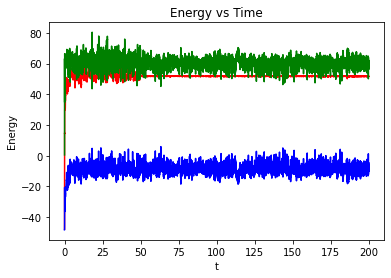

In [73]:
plt.xlabel('t') # Label for the x-axis
plt.ylabel('Energy') # Label for the y-axis
plt.title('Energy vs Time') # Title of plot
plt.plot(Time_List,Energy_List, color = 'r') 
plt.plot(Time_List,PotentialEnergy_List, color = 'b')
plt.plot(Time_List,KineticEnergy_List, color = 'g')


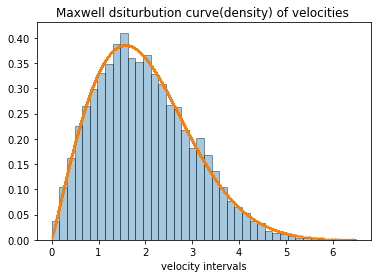

In [74]:
max_fun= []
for x in V_array:
    fun= x*(math.exp(-x**2/(2*T_eq)))/T_eq
    max_fun.append(fun)
sns.distplot(V_array,bins=40, hist_kws={'edgecolor':'black'},axlabel="velocity intervals",kde=False, norm_hist=True)
plt.title("Maxwell dsiturbution curve(density) of velocities ")
plt.plot(V_array, max_fun,'o',ms=0.2)
plt.show()

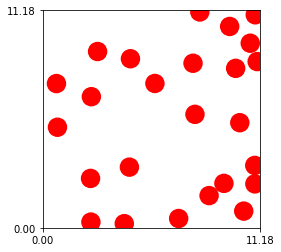

In [75]:
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), 0.5, fc='r')
        plt.gca().add_patch(atom)
create_picture(pos)

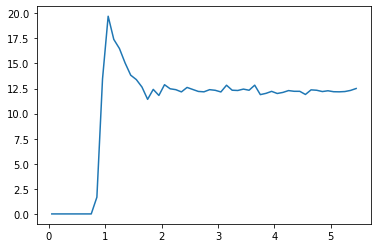

In [76]:
dist_d_list=[dist_list[i]/6 for i in range (0,len(dist_list))]
plt.plot(r_list, dist_d_list)